In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

In [3]:
sns.set_context('talk')
sns.set_style('white')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [4]:
dpath = 'orffinder_tmp'
summary_suffix = '.sorf.summary.csv.gz'
sorf_result_suffix = '.sorf.feather.gz'

In [7]:
protein_fname = r'Seq46351_QE2_specific-new-one peptide.xlsx'
protein_dpath = os.path.join('1A3','proteomics', 'with orfs DB')
protein_fpath = os.path.join(protein_dpath, protein_fname)

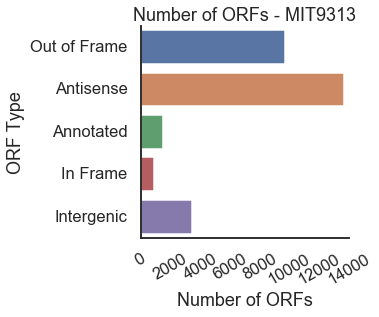

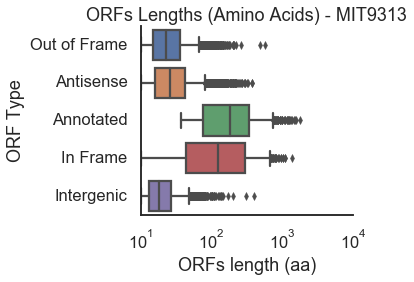

In [6]:
omap = {'standalone' : 'Intergenic', 
        'out_frame' : 'Out of Frame', 
        'antisense' : 'Antisense', 
        'in_frame' :'In Frame', 
        'known' : 'Annotated'}

genome = 'MIT9313'
df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.sorf.feather.gz'))
df = df.loc[df.otype != 'overlap']
df.otype = df.otype.map(omap)
    
sns.catplot(data=df, y='otype', kind='count', aspect=1.4, height=4,
       #order=oorder, palette=opalette
           )
plt.xticks(rotation=30) 
plt.ylabel('ORF Type')
plt.xlabel('Number of ORFs')
plt.title(f'Number of ORFs - {genome}')

sns.catplot(data=df, y='otype', x='len_aa', aspect=1.4, height=4,
        kind='box',
       #order=oorder, palette=opalette
           )
plt.xscale('log')
plt.ylabel('ORF Type')
plt.xlabel('ORFs length (aa)')

plt.title(f'ORFs Lengths (Amino Acids) - {genome}')
plt.show()
    

In [9]:
protein_df = pd.read_excel(protein_fpath, skiprows=1)

In [10]:
protein_df.head()

,Accession,Description,Score,Coverage,# Proteins,# Unique Peptides,# Peptides,# PSMs,Area,# AAs,MW [kDa],calc. pI,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,lcl,unnamed protein product - [ORF22701_BX548175.1...,264.49,74.73,1,9,9,66,7.47798e+10,91,9.82038,9.99365,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,A4,Sequence,# PSMs,# Proteins,# Protein Groups,Protein Group Accessions,Modifications,ΔCn,Area,q-Value,PEP,XCorr,Charge,MH+ [Da],ΔM [ppm],RT [min],# Missed Cleavages
2,NaN,High,TELTKTDVSLVVDAAIDTIIDSVVEGK,1,1,1,lcl,NaN,0,1.23224e+07,0,3.093e-16,8.84269,3,2831.51,-0.738287,232.912,1
3,NaN,High,TDVSLVVDAAIDTIIDSVVEGK,5,1,1,lcl,NaN,0,4.81268e+07,0,5.897e-15,7.60091,3,2259.19,-2.39155,233.944,0
4,NaN,High,TDVSLVVDAAIDTIIDSVVEGKK,2,1,1,lcl,NaN,0,6.16631e+07,0,5.524e-16,7.37785,3,2387.29,-2.2118,232.764,1


In [17]:
pdf = protein_df.dropna(subset=['Accession']).dropna(axis=1, how='all').reset_index(drop=True)

In [18]:
pdf.head()

,Accession,Description,Score,Coverage,# Proteins,# Unique Peptides,# Peptides,# PSMs,Area,# AAs,MW [kDa],calc. pI
0,lcl,unnamed protein product - [ORF22701_BX548175.1...,264.49,74.73,1,9,9,66,7.47798e+10,91,9.82038,9.99365
1,lcl,unnamed protein product - [ORF27991_BX548175.1...,780.223,94.95,1,6,6,129,62668485687,99,10.6449,4.09424
2,lcl,unnamed protein product - [ORF17148_BX548175.1...,438.661,72.82,1,9,9,100,6.19215e+10,103,10.8827,5.04639
3,lcl,unnamed protein product - [ORF8286_BX548175.1:...,374.565,58.82,1,9,9,73,56217832856,170,18.1622,4.94482
4,lcl,unnamed protein product - [ORF17149_BX548175.1...,4179.86,90.99,1,59,61,851,5.5555e+10,544,57.3609,5.0083


In [26]:
pdf['orfid'] = pdf['Description'].str.replace(r'unnamed protein product - \[', '').str.replace('\]$','')
pdf.head()

,Accession,Description,Score,Coverage,# Proteins,# Unique Peptides,# Peptides,# PSMs,Area,# AAs,MW [kDa],calc. pI,orfid
0,lcl,unnamed protein product - [ORF22701_BX548175.1...,264.49,74.73,1,9,9,66,7.47798e+10,91,9.82038,9.99365,ORF22701_BX548175.1:1481537:1481262
1,lcl,unnamed protein product - [ORF27991_BX548175.1...,780.223,94.95,1,6,6,129,62668485687,99,10.6449,4.09424,ORF27991_BX548175.1:1517947:1517648
2,lcl,unnamed protein product - [ORF17148_BX548175.1...,438.661,72.82,1,9,9,100,6.19215e+10,103,10.8827,5.04639,ORF17148_BX548175.1:1537470:1537159
3,lcl,unnamed protein product - [ORF8286_BX548175.1:...,374.565,58.82,1,9,9,73,56217832856,170,18.1622,4.94482,ORF8286_BX548175.1:1515352:1515864
4,lcl,unnamed protein product - [ORF17149_BX548175.1...,4179.86,90.99,1,59,61,851,5.5555e+10,544,57.3609,5.0083,ORF17149_BX548175.1:1537077:1535443


In [32]:
merge_df = pd.merge(df, pdf, how='left', on='orfid', suffixes=['','_p'])

In [33]:
merge_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,Score,Coverage,# Proteins,# Unique Peptides,# Peptides,# PSMs,Area,# AAs,MW [kDa],calc. pI
0,ORF1_BX548175.1:78:176,BX548175.1,78,176,78,176,+,MNENDLPLHFLLACEILGDLFSVLVLVVTLIQ,99,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ORF2_BX548175.1:453:590,BX548175.1,453,590,453,590,+,MRLVNRLNSKVQAGVIRCVGCLLMIFLNYLLLKVVRLSRLMRGLF,138,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ORF3_BX548175.1:669:722,BX548175.1,669,722,669,722,+,MVKPWKQRQLMVTALPF,54,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ORF4_BX548175.1:972:1025,BX548175.1,972,1025,972,1025,+,MVLLGVSMLIGVLLLQL,54,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ORF5_BX548175.1:1167:1205,BX548175.1,1167,1205,1167,1205,+,MLFRLLLMFVMY,39,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
merge_df.rename(columns={
    '# Proteins': 'Proteins', 
    '# Unique Peptides':'Unique Peptides', 
    '# Peptides' : 'Peptides', 
    '# PSMs': 'PSMs',
    '# AAs' : 'AAs'
}, inplace=True)

In [54]:
merge_df['multiple unique peptides'] = merge_df['Unique Peptides'] > 1
merge_df['has unique peptides'] = merge_df['Unique Peptides'] > 0


In [49]:
merge_df['multiple unique peptides'].value_counts()

False    28152
True      1133
Name: multiple unique peptides, dtype: int64

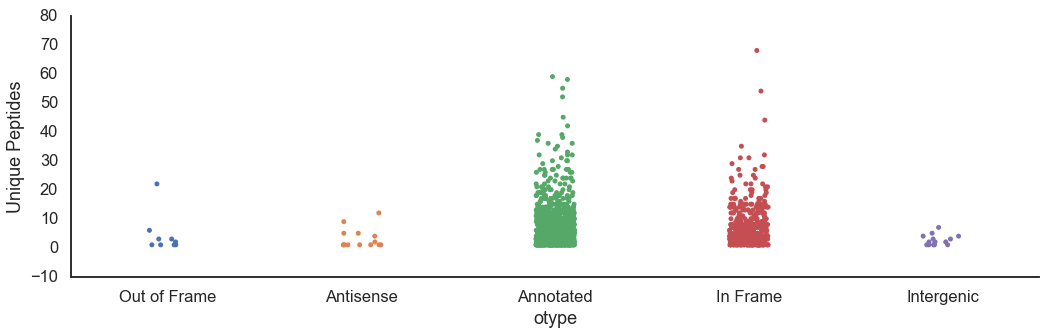

In [51]:
sns.catplot(data=merge_df, x='otype', y='Unique Peptides', aspect=3)

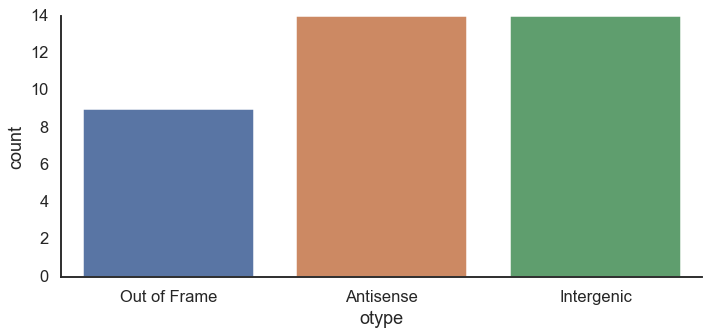

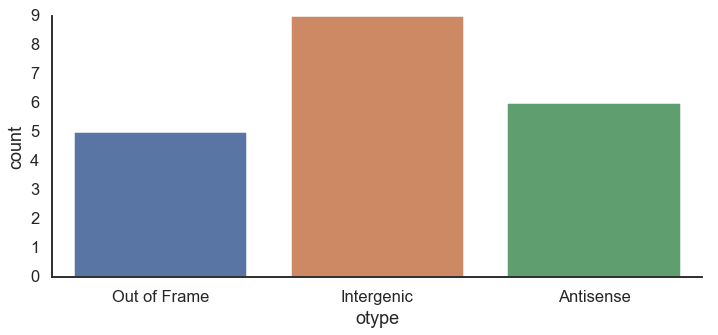

In [69]:
sns.catplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            x='otype', kind='count',  aspect=2)
sns.catplot(data=merge_df.loc[merge_df['multiple unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            x='otype', kind='count',  aspect=2)


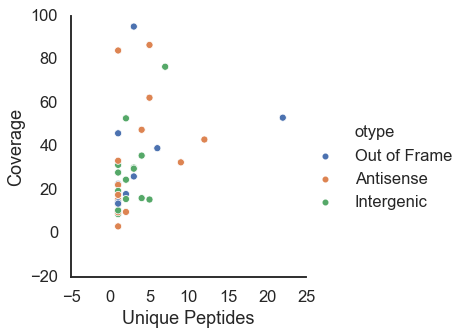

In [64]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            hue='otype', x='Unique Peptides', y='Coverage', s=50)


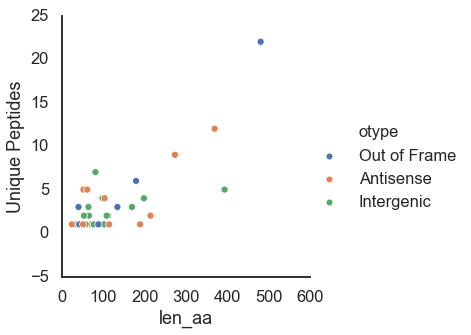

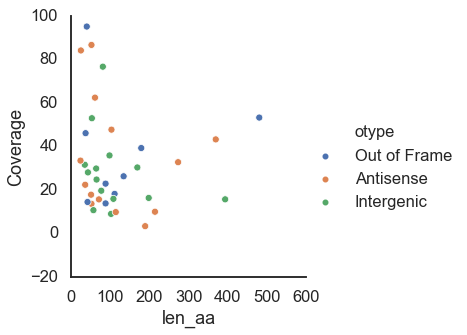

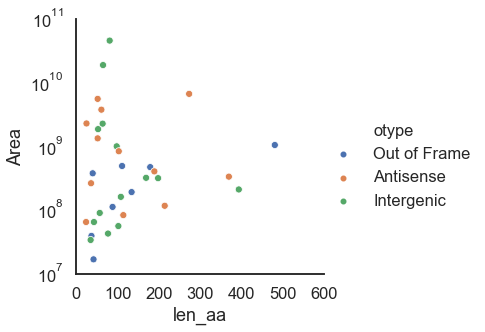

In [75]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            hue='otype', y='Unique Peptides', x='len_aa', s=50)
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            hue='otype', y='Coverage', x='len_aa', s=50)
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])], 
            hue='otype', y='Area', x='len_aa', s=50)
plt.yscale('log')

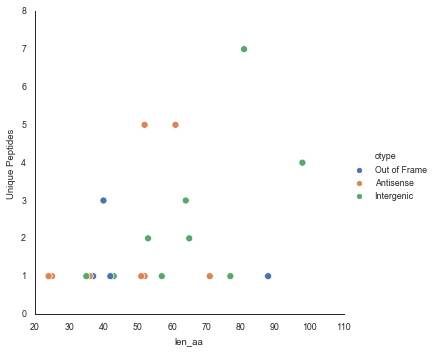

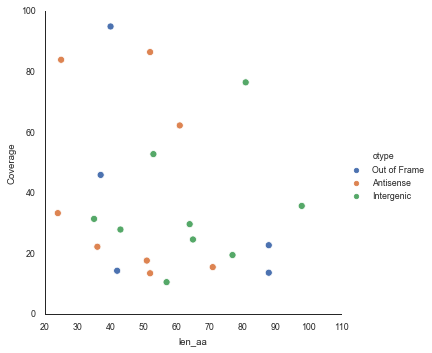

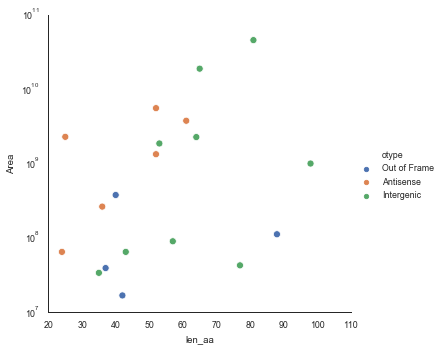

In [87]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue='otype', y='Unique Peptides', x='len_aa', s=50)
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue='otype', y='Coverage', x='len_aa', s=50)
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue='otype', y='Area', x='len_aa', s=50)
plt.yscale('log')

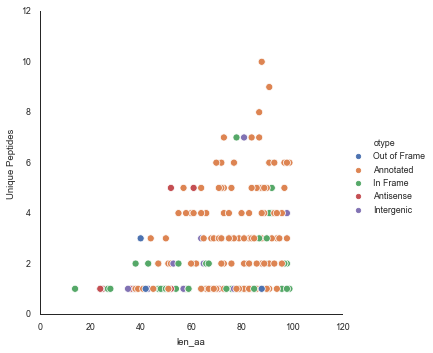

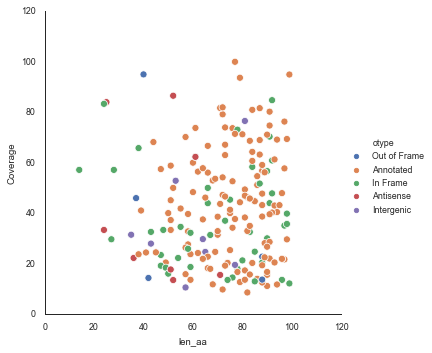

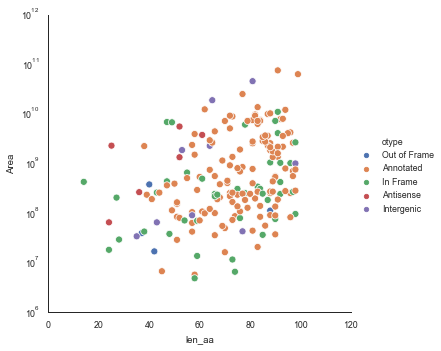

In [88]:
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] #& ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue='otype', y='Unique Peptides', x='len_aa', s=50)
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] #& ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue='otype', y='Coverage', x='len_aa', s=50)
sns.relplot(data=merge_df.loc[merge_df['has unique peptides'] #& ~merge_df.otype.isin(['Annotated', 'In Frame'])
                             & (merge_df.len_aa < 100)], 
            hue='otype', y='Area', x='len_aa', s=50)
plt.yscale('log')

In [73]:
merge_df.loc[merge_df['has unique peptides'] & ~merge_df.otype.isin(['Annotated', 'In Frame'])]['Unique Peptides'].value_counts()

1     17
2      5
3      4
5      3
4      3
22     1
12     1
9      1
7      1
6      1
Name: Unique Peptides, dtype: int64